<a href="https://colab.research.google.com/github/pedrohortencio/cancer-detection/blob/main/PCam/Detec%C3%A7%C3%A3o_Histopatol%C3%B3gica_de_C%C3%A2ncer_PCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção Histopatológica de Câncer Utilizando Aprendizado por Transferência

![](https://raw.githubusercontent.com/basveeling/pcam/master/pcam.jpg)

>## Universidade Federal de Goiás
>
>### Alunos:
>
>>* Gustavo 
>>
>>* Iago
>>
>>* Pedro




####Fonte dos Dados Utilizados:
<blockquote>

[Detecção Histopatológica de Câncer - Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

[PatchCamelyon (PCam) Dataset](https://github.com/basveeling/pcam)

</blockquote>
<hr>

## Importação de Bibliotecas e Download dos Dados

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import cv2
import os
import shutil


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, EfficientNetB1
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, LeakyReLU, Concatenate, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.metrics import plot_roc_curve

tf.random.set_seed(42)  #torna os números aleatórios gerados previsíveis, 
seed(42)    #de modo a ter consistência entre execuções. 42 escolhido arbitrariamente.


# Constantes
TAMANHO_IMAGEM = 96
CANAIS_IMAGEM = 3
TAMANHO_AMOSTRA = 20000

BATCH_SIZE_TREINO = 32
BATCH_SIZE_TESTE = 32

DATASET_PATH = "/content/dataset/"

# Muda o estilo de figuras que serão criadas no notebook
sns.set_theme(style='white', palette='deep')

>Os códigos da célula abaixo são necessários para o download do dataset do Kaggle. Para a correta execução, é necessário que seja gerado o arquivo ```kaggle.json```, que contém a autorização para uso da API. Mais informações podem ser obtidas na documentação da [API do Kaggle](https://www.kaggle.com/docs/api).

In [2]:
# Atualiza API do Kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle 

!mkdir -p ~/.kaggle                 # Cria o diretório para o arquivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json    # Muda as permissões do arquivo
!cp kaggle.json ~/.kaggle/          # Copia o arquivo kaggle.json para o diretório recém criado

# Download do arquivo zip para o caminho definido
!kaggle competitions download -c histopathologic-cancer-detection -p {DATASET_PATH}

     |████████████████████████████████| 61kB 8.5MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=b8da739ad4600c68ff77fdb58ac161051919e90bf47e5070510d412dc64f2f90
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
100% 6.30G/6.31G [02:17<00:00, 50.2MB/s]
100% 6.31G/6.31G [02:17<00:00, 49.4MB/s]


In [3]:
# Unzip do arquivo
!unzip -q {DATASET_PATH}histopathologic-cancer-detection.zip -d {DATASET_PATH}

## Criação de DataFrames

> O arquivo ```train_labels.csv``` contém o nome das imagens (armazenadas em duas pastas distintas, uma para treino e outra para teste) e o seu respectivo label.

In [24]:
df_dados = pd.read_csv(f'{DATASET_PATH}train_labels.csv')   # Cria um DataFrame
print(df_dados.shape)                                       # Formato (Linhas, Colunas)
df_dados.head(3)                                            # 3 primeiras linhas

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


In [25]:
# Checa a quantidade de imagens em cada diretório
print("Quantidade de Amostras de Treino:",
      len(os.listdir('/content/dataset/train')))

print("Quantidade de Amostras de Teste:",
      len(os.listdir('/content/dataset/test')))

Quantidade de Amostras de Treino: 220025
Quantidade de Amostras de Teste: 57458


> Plot para Visualização da Distribuição de Amostras para cada um dos labels

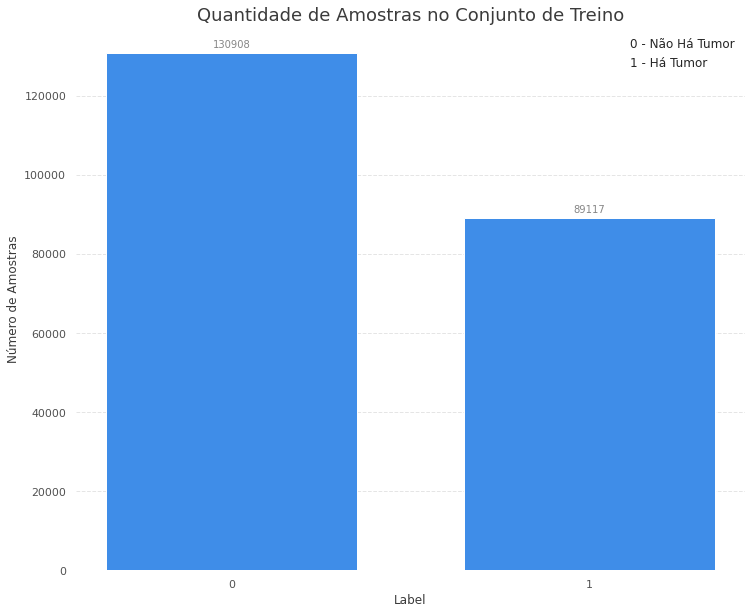

In [26]:
#@title Distribuição de amostras entre classes (original)
#@markdown _duplo clique para exibir o código_

count_label = df_dados['label'].value_counts() # conta a quantidade de amostras 0 e amostras 1

def autolabel(rects):
    """
    Essa é uma função auxiliar cujo único objetivo é anexar, ao topo de cada uma das barras do gráfico,
    o valor que ela representa.
    """
    for rect in rects:
        height = rect.get_height()  # Capta a altura da barra
        ax.annotate('{}'.format(height),    # Anota a altura
                    xy=(rect.get_x() + rect.get_width() / 2, height),   # Nessa posição (No "meio" da barra, na altura extraída)
                    xytext=(0, 3),  # Define um offset no valor de y
                    textcoords="offset points", # Estabelece que o offset deve ser seguido (para o texto ser anotado um pouco acima da altura da barra)
                    fontsize = 10,  # Tamanho da fonte
                    alpha=0.95, # Transparência da fonte
                    color='gray',   # Cor da fonte
                    ha='center',    # Alinhamento horizontal central
                    va='bottom',    # Alinhamento vertical inferior
                    )

fig = plt.figure(figsize=(12, 10))  # Cria a figura
ax = plt.gca()  # Criando uma variável ax com base no método "get current axes"

rects1 = plt.bar(x=list(count_label.index), height= list(count_label.values),   # Cria o plot. X = Labels, Y/Altura = Número de amostras.
                 width=0.7, # Largura das barras
                 color='#3f8de8')   # Cor do plot (azul)

autolabel(rects1)   # Chama a função criada anteriormente

plt.box(False)  # Desabilita as linhas envolvendo o plot

plt.grid(axis='y', alpha=0.5, ls="--")  # Exibe tracejados no eixo y

plt.title("Quantidade de Amostras no Conjunto de Treino", size=18, alpha=0.9)   # Título da imagem
plt.ylabel("Número de Amostras", alpha=0.9) # Nome do eixo y
plt.xlabel("Label", alpha=0.9)      # Nome do eixo x
plt.xticks([0, 1], alpha=0.8)   # Definindo quais são os pontos a serem marcados no eixo x
plt.yticks(alpha=0.8)       # Define a transparência do texto no eixo y

# Cria uma legenda personalizada
patch_legenda0 = mpatches.Patch(color='none', label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none', label='1 - Há Tumor')
plt.legend(handles=[patch_legenda0, patch_legenda1],
           edgecolor='white',
           prop={'size':12},
           )

plt.show();

In [27]:
# Iguala a quantidade de amostras com label 0 e amostras com label 1

df_0 = df_dados[df_dados['label'] == 0].sample(TAMANHO_AMOSTRA,
                                               random_state = 42)    # Apenas imagens com label 0
df_1 = df_dados[df_dados['label'] == 1].sample(TAMANHO_AMOSTRA,
                                               random_state = 42)    # Apenas imagens com label 1

# Concatena os dataframes e embaralha (shuffle) as imagens
df_dados = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_dados = shuffle(df_dados)

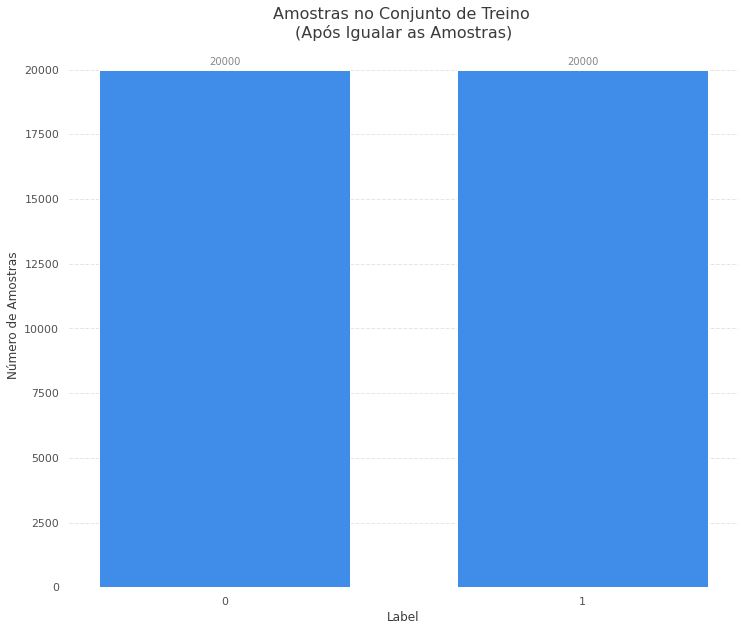

In [28]:
#@markdown Distribuição após igualar a quantidade de amostras por classe
#@markdown
#@markdown _duplo clique para exibir o código_

count_label = df_dados['label'].value_counts() # conta a quantidade de amostras 0 e amostras 1

def autolabel(rects):
    """
    Essa é uma função auxiliar cujo único objetivo é anexar, ao topo de cada uma das barras do gráfico,
    o valor que ela representa.
    """
    for rect in rects:
        height = rect.get_height()  # Capta a altura da barra
        ax.annotate('{}'.format(height),    # Anota a altura
                    xy=(rect.get_x() + rect.get_width() / 2, height),   # Nessa posição (No "meio" da barra, na altura extraída)
                    xytext=(0, 3),  # Define um offset no valor de y
                    textcoords="offset points", # Estabelece que o offset deve ser seguido (para o texto ser anotado um pouco acima da altura da barra)
                    fontsize = 10,  # Tamanho da fonte
                    alpha=0.95, # Transparência da fonte
                    color='gray',   # Cor da fonte
                    ha='center',    # Alinhamento horizontal central
                    va='bottom',    # Alinhamento vertical inferior
                    )

fig = plt.figure(figsize=(12, 10))  # Cria a figura
ax = plt.gca()  # Criando uma variável ax com base no método "get current axes"

rects1 = plt.bar(x=list(count_label.index), height= list(count_label.values),   # Cria o plot. X = Labels, Y/Altura = Número de amostras.
                 width=0.7, # Largura das barras
                 color='#3f8de8')   # Cor do plot (azul)

autolabel(rects1)   # Chama a função criada anteriormente

plt.box(False)  # Desabilita as linhas envolvendo o plot

plt.grid(axis='y', alpha=0.5, ls="--")  # Exibe tracejados no eixo y

plt.title("Amostras no Conjunto de Treino \n(Após Igualar as Amostras)", size=16, alpha=0.9)   # Título da imagem
plt.ylabel("Número de Amostras", alpha=0.9) # Nome do eixo y
plt.xlabel("Label", alpha=0.9)      # Nome do eixo x
plt.xticks([0, 1], alpha=0.8)   # Definindo quais são os pontos a serem marcados no eixo x
plt.yticks(alpha=0.8)       # Define a transparência do texto no eixo y

# Cria uma legenda personalizada
patch_legenda0 = mpatches.Patch(color='none', label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none', label='1 - Há Tumor')
#plt.legend(handles=[patch_legenda0, patch_legenda1],
#           edgecolor='white',
#           framealpha = 0,
#           prop={'size':12},
#           )

plt.show();

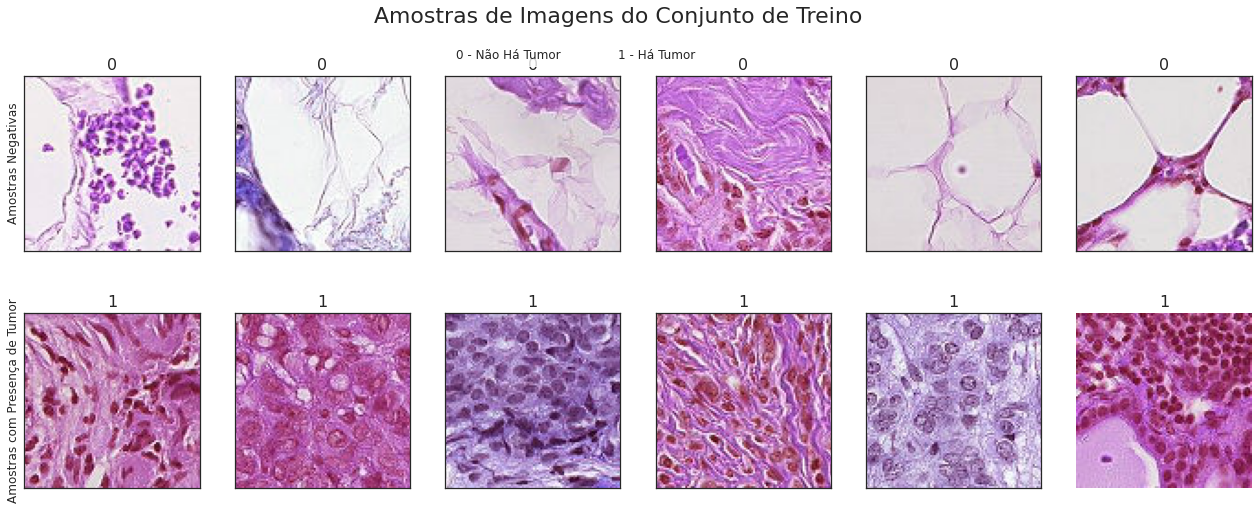

In [29]:
#@title Exemplo de Imagens
#@markdown A seleção de imagens a serem exibidas é aleatória
#@markdown
#@markdown _duplo clique exibe o código_

# Constantes que serão usadas nessa célula
nome_coluna = 'label'
figure_cols = 6
df = df_dados
IMAGE_PATH = '/content/dataset/train/' 

# Cria uma variável index com os valores dos labels e o nome da coluna
categories = (df.groupby([nome_coluna])[nome_coluna].nunique()).index

# Cria a figura
f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                      figsize=(22,8))

# Loop sobre o index criado anteriormente
for i, cat in enumerate(categories):
    # Seleciona aleatoriamente (figure_cols) imagens
    sample = df[df[nome_coluna]==cat].sample(figure_cols)

    # Loop que preenche os subplots com as imagens elecionadas
    for j in range(0,figure_cols):
        file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'     # Gera o caminho da imagem
        im=cv2.imread(file)                                 # Lê a imagem
        ax[i, j].imshow(im, resample=True, cmap='gray')     # Plota a imagem
        ax[i, j].set_title(cat, fontsize=16)                # Cria um título
        ax[i, j].grid(False)                                # Desabilita o grid
        plt.box(False)                              # Desabilita a caixa do gráfico
        ax[i, j].set_xticks([])                     # Desabilita os números no eixo x
        ax[i, j].set_yticks([])                     # Desabilita os números no eixo y

# Cria labels (do matplotlib) para serem exibidos na legenda da imagem
patch_legenda0 = mpatches.Patch(color='none',   
                                label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none',
                                label='1 - Há Tumor')

ax[0,0].set_ylabel('Amostras Negativas', size='large')
ax[1,0].set_ylabel('Amostras com Presença de Tumor', size='large')

# Adiciona uma legenda na imagem, com base nos labels anteriores
f.legend(handles=[patch_legenda0, patch_legenda1],
           edgecolor='white',                   # Cor da borda
           prop={'size':12},                    # Tamanho da fonte
           ncol=2,                              # Número de colunas
           bbox_to_anchor=(0.26, .76, 1, 1),    #(x, y, width, height)
           loc=3,                               # Posição
           )
f.suptitle("Amostras de Imagens do Conjunto de Treino",
           size=22, y=0.98)

# Salva a imagem
plt.savefig("Amostra-Treino.png",
            bbox_inches='tight', dpi=100)

# Realiza o plot
plt.show()

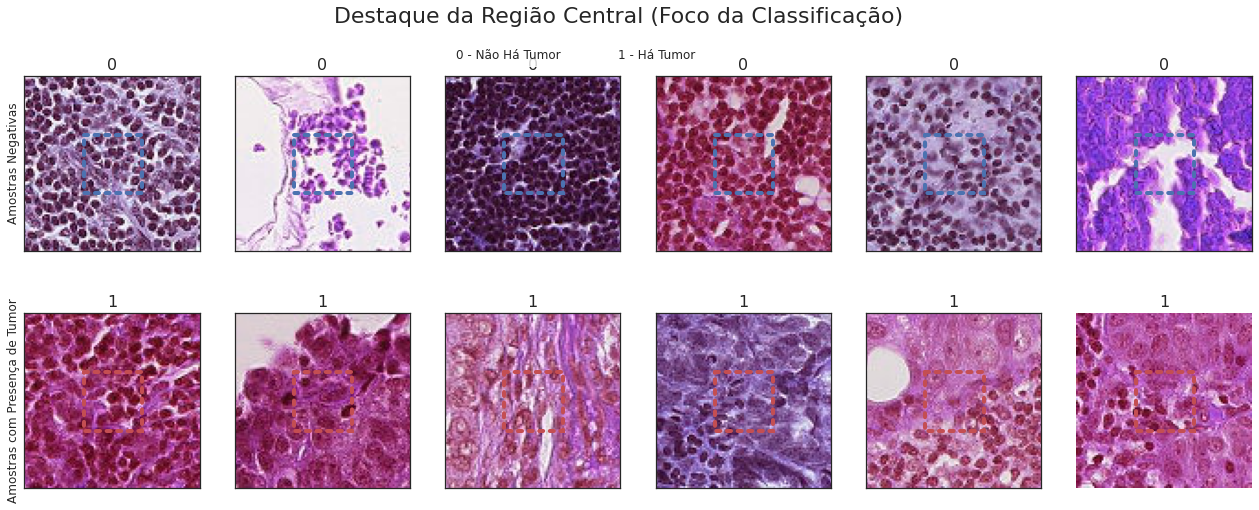

In [30]:
#@title Exemplo de Imagens (Com Destaque Para a Região Central)
#@markdown A seleção de imagens a serem exibidas é aleatória. O destaque é feito na região central das imagens, de tamanho 32x32 pixels, e delimita a região que é levada em consideração para a classificação dos labels originais.
#@markdown
#@markdown _duplo clique exibe o código_

# Constantes que serão usadas nessa célula
nome_coluna = 'label'
figure_cols = 6
df = df_dados
IMAGE_PATH = '/content/dataset/train/' 

# Cria uma variável index com os valores dos labels e o nome da coluna
categories = (df.groupby([nome_coluna])[nome_coluna].nunique()).index

# Cria a figura
f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                      figsize=(22,8))

# Loop sobre o index criado anteriormente
for i, cat in enumerate(categories):
    # Seleciona aleatoriamente (figure_cols) imagens
    sample = df[df[nome_coluna]==cat].sample(figure_cols)

    # Loop que preenche os subplots com as imagens elecionadas
    for j in range(0,figure_cols):
        file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'     # Gera o caminho da imagem
        im=cv2.imread(file)                                 # Lê a imagem
        ax[i, j].imshow(im, resample=True, cmap='gray')     # Plota a imagem
        
        if cat == 0:
            color = 'b'
        else:
            color = 'r'
        
        box = mpatches.Rectangle((32,32),32,32,linewidth=4,edgecolor=color,facecolor='none', linestyle=':', capstyle='round')
        ax[i, j].add_patch(box)
        ax[i, j].set_title(cat, fontsize=16)                # Cria um título
        ax[i, j].grid(False)                                # Desabilita o grid
        plt.box(False)                              # Desabilita a caixa do gráfico
        ax[i, j].set_xticks([])                     # Desabilita os números no eixo x
        ax[i, j].set_yticks([])                     # Desabilita os números no eixo y

# Cria labels (do matplotlib) para serem exibidos na legenda da imagem
patch_legenda0 = mpatches.Patch(color='none',   
                                label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none',
                                label='1 - Há Tumor')

ax[0,0].set_ylabel('Amostras Negativas', size='large')
ax[1,0].set_ylabel('Amostras com Presença de Tumor', size='large')

# Adiciona uma legenda na imagem, com base nos labels anteriores
f.legend(handles=[patch_legenda0, patch_legenda1],
           edgecolor='white',                   # Cor da borda
           prop={'size':12},                    # Tamanho da fonte
           ncol=2,                              # Número de colunas
           bbox_to_anchor=(0.26, .76, 1, 1),    #(x, y, width, height)
           loc=3,                               # Posição
           )
f.suptitle("Destaque da Região Central (Foco da Classificação)",
           size=22, y=0.98)

# Salva a imagem
plt.savefig("Amostra-Treino-Patch.png",
            bbox_inches='tight', dpi=100)

# Realiza o plot
plt.show()

## Criando DataFrames de Validação e Treino

In [31]:
y = df_dados['label']           # Array de labels

df_treino, df_val = train_test_split(df_dados,
                                    test_size=0.25,     # Conjunto de teste com 25% dos dados
                                    random_state=42,
                                    stratify=y)         # Cria uma divisão balanceada

print("Dataset de treino:", df_treino.shape)
print("Dataset de validação:", df_val.shape)

Dataset de treino: (30000, 2)
Dataset de validação: (10000, 2)


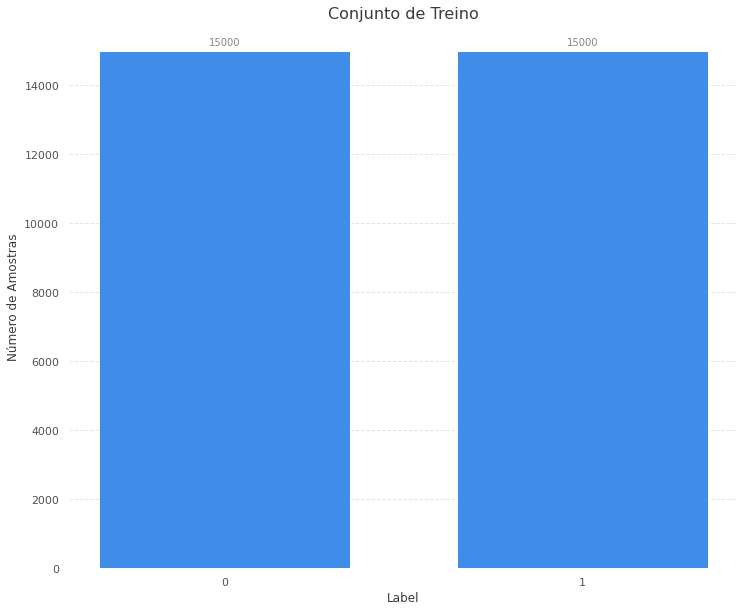

In [32]:
#@markdown Distribuição do Conjunto Final de Testes
#@markdown
#@markdown _duplo clique para exibir o código_

count_label = df_treino['label'].value_counts() # conta a quantidade de amostras 0 e amostras 1

def autolabel(rects):
    """
    Essa é uma função auxiliar cujo único objetivo é anexar, ao topo de cada uma das barras do gráfico,
    o valor que ela representa.
    """
    for rect in rects:
        height = rect.get_height()  # Capta a altura da barra
        ax.annotate('{}'.format(height),    # Anota a altura
                    xy=(rect.get_x() + rect.get_width() / 2, height),   # Nessa posição (No "meio" da barra, na altura extraída)
                    xytext=(0, 3),  # Define um offset no valor de y
                    textcoords="offset points", # Estabelece que o offset deve ser seguido (para o texto ser anotado um pouco acima da altura da barra)
                    fontsize = 10,  # Tamanho da fonte
                    alpha=0.95, # Transparência da fonte
                    color='gray',   # Cor da fonte
                    ha='center',    # Alinhamento horizontal central
                    va='bottom',    # Alinhamento vertical inferior
                    )

fig = plt.figure(figsize=(12, 10))  # Cria a figura
ax = plt.gca()  # Criando uma variável ax com base no método "get current axes"

rects1 = plt.bar(x=list(count_label.index), height= list(count_label.values),   # Cria o plot. X = Labels, Y/Altura = Número de amostras.
                 width=0.7, # Largura das barras
                 color='#3f8de8')   # Cor do plot (azul)

autolabel(rects1)   # Chama a função criada anteriormente

plt.box(False)  # Desabilita as linhas envolvendo o plot

plt.grid(axis='y', alpha=0.5, ls="--")  # Exibe tracejados no eixo y

plt.title("Conjunto de Treino", size=16, alpha=0.9)   # Título da imagem
plt.ylabel("Número de Amostras", alpha=0.9) # Nome do eixo y
plt.xlabel("Label", alpha=0.9)      # Nome do eixo x
plt.xticks([0, 1], alpha=0.8)   # Definindo quais são os pontos a serem marcados no eixo x
plt.yticks(alpha=0.8)       # Define a transparência do texto no eixo y

# Cria uma legenda personalizada
patch_legenda0 = mpatches.Patch(color='none', label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none', label='1 - Há Tumor')
#plt.legend(handles=[patch_legenda0, patch_legenda1],
#           edgecolor='white',
#           framealpha = 0,
#           prop={'size':12},
#           )

plt.show();

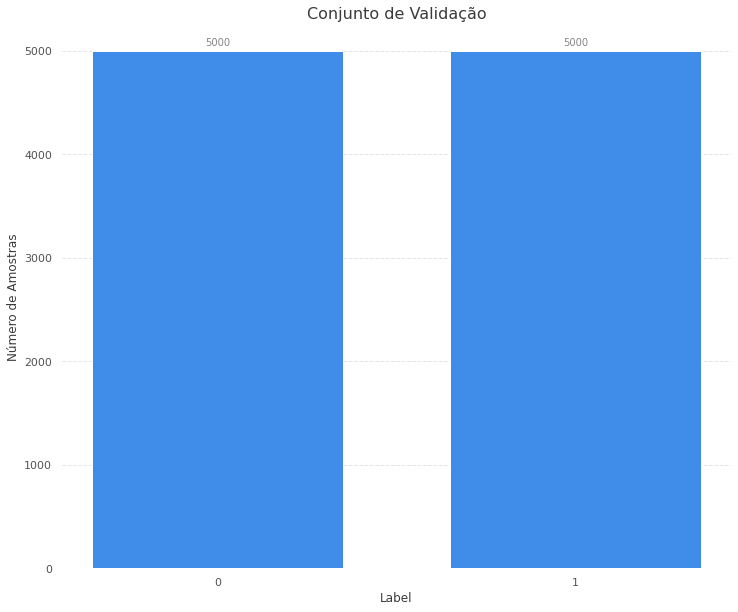

In [33]:
#@markdown Distribuição do Conjunto Final de Validação
#@markdown
#@markdown _duplo clique para exibir o código_

count_label = df_val['label'].value_counts() # conta a quantidade de amostras 0 e amostras 1

def autolabel(rects):
    """
    Essa é uma função auxiliar cujo único objetivo é anexar, ao topo de cada uma das barras do gráfico,
    o valor que ela representa.
    """
    for rect in rects:
        height = rect.get_height()  # Capta a altura da barra
        ax.annotate('{}'.format(height),    # Anota a altura
                    xy=(rect.get_x() + rect.get_width() / 2, height),   # Nessa posição (No "meio" da barra, na altura extraída)
                    xytext=(0, 3),  # Define um offset no valor de y
                    textcoords="offset points", # Estabelece que o offset deve ser seguido (para o texto ser anotado um pouco acima da altura da barra)
                    fontsize = 10,  # Tamanho da fonte
                    alpha=0.95, # Transparência da fonte
                    color='gray',   # Cor da fonte
                    ha='center',    # Alinhamento horizontal central
                    va='bottom',    # Alinhamento vertical inferior
                    )

fig = plt.figure(figsize=(12, 10))  # Cria a figura
ax = plt.gca()  # Criando uma variável ax com base no método "get current axes"

rects1 = plt.bar(x=list(count_label.index), height= list(count_label.values),   # Cria o plot. X = Labels, Y/Altura = Número de amostras.
                 width=0.7, # Largura das barras
                 color='#3f8de8')   # Cor do plot (azul)

autolabel(rects1)   # Chama a função criada anteriormente

plt.box(False)  # Desabilita as linhas envolvendo o plot

plt.grid(axis='y', alpha=0.5, ls="--")  # Exibe tracejados no eixo y

plt.title("Conjunto de Validação", size=16, alpha=0.9)   # Título da imagem
plt.ylabel("Número de Amostras", alpha=0.9) # Nome do eixo y
plt.xlabel("Label", alpha=0.9)      # Nome do eixo x
plt.xticks([0, 1], alpha=0.8)   # Definindo quais são os pontos a serem marcados no eixo x
plt.yticks(alpha=0.8)       # Define a transparência do texto no eixo y

# Cria uma legenda personalizada
patch_legenda0 = mpatches.Patch(color='none', label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none', label='1 - Há Tumor')
#plt.legend(handles=[patch_legenda0, patch_legenda1],
#           edgecolor='white',
#           framealpha = 0,
#           prop={'size':12},
#           )

plt.show();

## Estrutura de Diretórios para Utilização do Keras DataGenerator

In [ ]:
# Criando uma nova pasta/diretório
dir_base = 'dir_base'
os.mkdir(dir_base)

# Dentro da pasta "dir_base", haverá a seguinte estrutura:

# dir_treino
    # a_sem_tumor
    # b_com_tumor

# dir_val
    # a_sem_tumor
    # b_com_tumor


# Criando a pasta "dir_treino"
dir_treino = os.path.join(dir_base, 'dir_treino')
os.mkdir(dir_treino)

# Criando a pasta "dir_val"
dir_val = os.path.join(dir_base, 'dir_val')
os.mkdir(dir_val)


# Criando as pastas que ficarão dentro das pastas "dir_treino" e "dir_val"
# Dentro dessas pastas estarão as imagens correspondentes a cada um dos labels

# Crindo pastas dentro de "dir_treino"
no_tumor_tissue = os.path.join(dir_treino, 'a_sem_tumor')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(dir_treino, 'b_com_tumor')
os.mkdir(has_tumor_tissue)

# Criando pastas dentro de "dir_val"
no_tumor_tissue = os.path.join(dir_val, 'a_sem_tumor')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(dir_val, 'b_com_tumor')
os.mkdir(has_tumor_tissue)

In [35]:
# Checando as pastas no diretório de treino
os.listdir('dir_base/dir_treino')

['b_com_tumor', 'a_sem_tumor']

### Transferindo Imagens

In [36]:
# Configurando o id das imagens como index do dataframe
df_dados.set_index('id', inplace=True)

In [37]:
df_dados.head(2)

,label
id,
2dace9fd7d8a65d4c1dac590f69e15b575126d73,1
c20ab768384aa2249648e25260c24e6f3367fa1c,0


In [38]:
# Cria listas com base nos IDs das imagens de treino e validação
list_treino = list(df_treino['id'])
list_val = list(df_val['id'])

# Mudando as imagens de pasta
for image in list_treino:
    
    fname = image + '.tif'                  # Adiciona o .tif no final do ID
    target = df_dados.loc[image,'label']    # Identifica o label da imagem
    
    # Define a pasta em que a imagem será salva
    if target == 0:
        label = 'a_sem_tumor'
    if target == 1:
        label = 'b_com_tumor'
    
    src = os.path.join('/content/dataset/train', fname)     # Define o caminho de origem
    dst = os.path.join(dir_treino, label, fname)            # Define o caminho de destino
    
    shutil.copyfile(src, dst)                   # Copia a imagem de uma pasta para outra


# Mesmo processo, mas para as imagens de validação

for image in list_val:
    
    fname = image + '.tif'
    target = df_dados.loc[image,'label']
    
    if target == 0:
        label = 'a_sem_tumor'
    if target == 1:
        label = 'b_com_tumor'
    
    src = os.path.join('/content/dataset/train', fname)
    dst = os.path.join(dir_val, label, fname)
    
    shutil.copyfile(src, dst)

In [39]:
print("Imagens de treino")
print("\t Label 0 (Sem tumor):", 
      len(os.listdir('dir_base/dir_treino/a_sem_tumor')))
print("\t Label 1 (Com tumor):", 
      len(os.listdir('dir_base/dir_treino/b_com_tumor')))

print("\nImagens de validação")
print("\t Label 0 (Sem tumor):", 
      len(os.listdir('dir_base/dir_val/a_sem_tumor')))
print("\t Label 1 (Com tumor):", 
      len(os.listdir('dir_base/dir_val/b_com_tumor')))

Imagens de treino
	 Label 0 (Sem tumor): 18808
	 Label 1 (Com tumor): 18735

Imagens de validação
	 Label 0 (Sem tumor): 8808
	 Label 1 (Com tumor): 8735


## Criando Geradores (Keras)

Estamos lidando com um dataset bastante grande. Nesse caso, um desafio considerável é alimentar o modelo com as imagens sem que o sistema em questão fique sem memória RAM (já que, usualmente, todas as imagens seriam carregadas na memória e, então, fornecidas de uma só vez ao modelo).


Uma forma de contornar esse problema, para datasets com muitas imagens, é utilizar alguma ferramenta que alimenta os modelos em _batches_. Uma dessas ferrametnas é o [_ImageDataGenerator_](https://keras.io/api/preprocessing/image/), do Keras. É uma ferramenta muito poderosa para o processo de _data augmentation_, pois não só carrega as imagens em _batches_, mas também modifica as imagens antes de alimentar o modelo.


In [40]:
train_path = 'dir_base/dir_treino'      # Caminho das imagens de treino
valid_path = 'dir_base/dir_val'         # Caminho das imagens de validação
test_path = '/content/dataset/test'     # Caminho das imagens de teste

num_amostras_treino = len(df_treino)    # Número de amostras de treino
num_amostras_val = len(df_val)          # Número de amostras de validação

passos_treino = np.ceil(num_amostras_treino / BATCH_SIZE_TREINO)    # Quantidade de passos por época (treino)
passos_val = np.ceil(num_amostras_val / BATCH_SIZE_TESTE)           # Quantidade de passos por época (validação)
            # np.ceil(número) arredonda um número decimal para cima

Em casos onde se é utilizado um modelo pré-treinado (utilizando os princípios de _Transfer Learning_), é necessário que os inputs (no caso, as imagens) seja pré-processado para corresponder ao formato de imagens que o modelo virou durante o treinamento.

Isso se deve ao fato de que há muitos tipos de normalização dos dados. Podem simplesmente terem sido divididos por 255, ou pela média e desvio padrão, ou centralizados utilizando algum modelo estatístico.

Com o Keras, isso é facilmente feito chamando uma função, que varia de modelo para modelo, disponível na documentação do framework.

In [41]:
# Cria uma instância do ImageDataGenerator
# Define também a função que deve ser utilizada para processar cada imagem.
datagen_treino = ImageDataGenerator(preprocessing_function=preprocess_input,
                             horizontal_flip=True)

datagen_teste = ImageDataGenerator(preprocessing_function=preprocess_input)


# Definindo o gerador para as imagens de treino
train_gen = datagen_treino.flow_from_directory(
                        train_path,     # Caminho das imagens
                        target_size=(TAMANHO_IMAGEM,TAMANHO_IMAGEM),    # Tamanho da imagem
                        batch_size=BATCH_SIZE_TREINO,   # Tamanho de cada batch
                        class_mode='categorical')   # Tipo de classificação

# Definindo o gerador para as imagens de validação
val_gen = datagen_teste.flow_from_directory(
                        valid_path,
                        target_size=(TAMANHO_IMAGEM,TAMANHO_IMAGEM),
                        batch_size=BATCH_SIZE_TESTE,
                        class_mode='categorical')

# Definindo o gerador para as imagens de teste
test_gen = datagen_teste.flow_from_directory(
                        '/content/dataset', classes=['test'],
                        target_size=(TAMANHO_IMAGEM,TAMANHO_IMAGEM),
                        batch_size=1,               # Teste será gerado imagem a imagem
                        class_mode=None,   
                        shuffle=False)              # e as imagens não serão embaralhadas

Found 37543 images belonging to 2 classes.
Found 17543 images belonging to 2 classes.
Found 57458 images belonging to 1 classes.


## Criação do Modelo

O Keras oferece alguns modelos pré-treinados, listado na parte de [Applications](https://keras.io/api/applications/) do framework.

> [Artigo EfficientNet](https://arxiv.org/abs/1905.11946)
>
> [GitHub EfficientNet](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet)

In [ ]:
#@markdown Download de pesos atualizados, derivados do treinamento da EfficientNet através do método _Noisy Student_.
#@markdown
#@markdown _duplo clique para exibir código_

import urllib
import urllib.request

url = 'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz'
filename, headers = urllib.request.urlretrieve(url, filename="/content/noisy_student_efficientnet-b0.tar.gz")

url = 'https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py'
filename, headers = urllib.request.urlretrieve(url, filename="/content/efficientnet_weight_update_util.py")

!tar -xf noisy_student_efficientnet-b0.tar.gz

!python efficientnet_weight_update_util.py --model b0 --notop --ckpt \
        /content/noisy_student_efficientnet-b0/model.ckpt --o  efficientnetb0_notop.h5

In [42]:
### EfficientNetB0

conv_base = EfficientNetB0(weights='/content/efficientnetb0_notop.h5',  #weights='imagenet'
                           include_top=False,
                           input_shape=(96,96,3))
conv_base.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 96, 96, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 96, 96, 3)    7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 97, 97, 3)    0           normalization_1[0][0]            
_____________________________________________________________________________________

In [ ]:
"""inputs = Input((TAMANHO_IMAGEM, TAMANHO_IMAGEM, 3))

conv1 = conv_base(inputs)

out1 = GlobalMaxPooling2D()(conv1)
out2 = GlobalAveragePooling2D()(conv1)

concat = Concatenate(axis=-1)([out1, out2])

bn1 = BatchNormalization()(concat)

dropout1 = Dropout(0.1)(bn1)

dense1 = Dense(256, activation='relu')(dropout1)
dropout2 = Dropout(0.1)(dense1)

dense2 = Dense(32, activation='relu')(dropout2)

out = Dense(2, activation='softmax')(dense2)

model = keras.models.Model(inputs, out)"""

In [43]:
from tensorflow.keras.layers import MaxPooling2D

In [49]:
# Layer que recebe as imagens
inputs = Input((TAMANHO_IMAGEM, TAMANHO_IMAGEM, 3))

# Base convolucional retirada do modelo EfficientNetB0
conv1 = conv_base(inputs)

# A saída (2D) é convertida para um formato 1D, através da operação de pooling
out1 = GlobalMaxPooling2D()(conv1)                  # Valor máximo de cada feature map
out2 = GlobalAveragePooling2D()(conv1)              # Valor médio de cada feature map

# Aplica a operação MaxPooling na saída do modelo convolucional
maxPool1 = MaxPooling2D(padding="same")(conv1)  
out3 = Flatten()(maxPool1)                      # Resultados são convertidos diretamente para 1D

# Concatenando as três saídas
concat = Concatenate(axis=-1)([out1, out2, out3])

# Primeira camada MLP
dense1 = Dense(256)(concat)
bn1 = BatchNormalization()(dense1)
relu1 = ReLU()(bn1)

# Segunda camada MLP
dense2 = Dense(128)(relu1)
relu2 = ReLU()(dense2)

# Terceira camada MLP
dense3 = Dense(64)(relu2)
bn2 = BatchNormalization()(dense3)
relu3 = ReLU()(bn2)

# Neurônios de saída
out = Dense(2, activation='softmax')(relu3)

# Construindo o modelo
model = keras.models.Model(inputs, out)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 3, 3, 1280)   4049571     input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 2, 2, 1280)   0           efficientnetb0[5][0]             
__________________________________________________________________________________________________
global_max_pooling2d_4 (GlobalM (None, 1280)         0           efficientnetb0[5][0]             
____________________________________________________________________________________________

In [50]:
print('Quantidade de pesos treináveis antes do congelamento da base convolucional:', len(model.trainable_weights))
conv_base.trainable = False
print('Quantidade de pesos treináveis após o congelamento da base convolucional:', len(model.trainable_weights))

Quantidade de pesos treináveis antes do congelamento da base convolucional: 223
Quantidade de pesos treináveis após o congelamento da base convolucional: 12


In [51]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 3, 3, 1280)   4049571     input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 2, 2, 1280)   0           efficientnetb0[5][0]             
__________________________________________________________________________________________________
global_max_pooling2d_4 (GlobalM (None, 1280)         0           efficientnetb0[5][0]             
____________________________________________________________________________________________

In [53]:
model.compile(Adam(lr=0.005), loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall()])

In [54]:
print(train_gen.class_indices)
print(val_gen.class_indices)

{'a_sem_tumor': 0, 'b_com_tumor': 1}
{'a_sem_tumor': 0, 'b_com_tumor': 1}


In [56]:
filepath = "content/model.h5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                              verbose=1, mode='max', min_lr=0.00001)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [57]:
history = model.fit(train_gen, steps_per_epoch=passos_treino, 
                              validation_data=val_gen,
                              validation_steps=passos_val,
                              epochs=40, verbose=1,
                              callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/40
938/938 [==============================] - 80s 45ms/step - loss: 0.4634 - accuracy: 0.7834 - auc_1: 0.8607 - recall_1: 0.7834 - val_loss: 0.4312 - val_accuracy: 0.7852 - val_auc_1: 0.8823 - val_recall_1: 0.7852

Epoch 00001: val_accuracy improved from -inf to 0.78524, saving model to content/model.h5
Epoch 2/40
938/938 [==============================] - 35s 37ms/step - loss: 0.3819 - accuracy: 0.8259 - auc_1: 0.9077 - recall_1: 0.8259 - val_loss: 0.3256 - val_accuracy: 0.8578 - val_auc_1: 0.9347 - val_recall_1: 0.8578

Epoch 00002: val_accuracy improved from 0.78524 to 0.85783, saving model to content/model.h5
Epoch 3/40
938/938 [==============================] - 34s 36ms/step - loss: 0.3666 - accuracy: 0.8364 - auc_1: 0.9152 - recall_1: 0.8364 - val_loss: 0.3451 - val_accuracy: 0.8420 - val_auc_1: 0.9250 - val_recall_1: 0.8420

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 00003: val_accuracy did not improve from 0.85783
Epoch 4/40
9

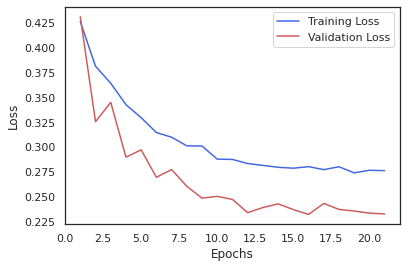

In [58]:
epochs = range(1, len(history.history['loss'])+1)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']


# b+ is for "blue cross"
plt.plot(epochs, training_loss, color='royalblue', label='Training Loss')
# "bo" is for "blue dot"
plt.plot(epochs, validation_loss, color='indianred', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

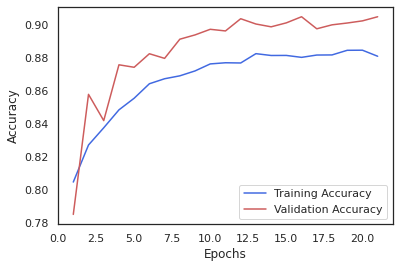

In [59]:
epochs = range(1, len(history.history['loss'])+1)
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']


# b+ is for "blue cross"
plt.plot(epochs, training_acc, color='royalblue', label='Training Accuracy')
# "bo" is for "blue dot"
plt.plot(epochs, validation_acc, color='indianred', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

> Se necessário, os pesos da rede podem ser restaurados para o último checkpoint realizado durante o treinamento. Útil em casos onde o modelo decaiu nas métricas observadas entre o checkpoint e o fim do treinamento.

In [ ]:
#model.load_weights('/content/content/model.h5')

### Fine-Tuning

In [60]:
conv_base.trainable = True

flag = False
set_trainable = False

for layer in conv_base.layers:
    if layer.name.startswith('block3'):
        flag = True
    
    if flag:
        # Somente layers do bloco 3 a 7
        if layer.name.endswith('bn'):
            # Layers de batch normalization
            layer.trainable = False
            continue
        else:
            # Demais layers dos blocos 3 a 7
            layer.trainable = True
    else:
        # Layers até a camada 3
        layer.trainable = False

In [61]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall()])

In [62]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 3, 3, 1280)   4049571     input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 2, 2, 1280)   0           efficientnetb0[5][0]             
__________________________________________________________________________________________________
global_max_pooling2d_4 (GlobalM (None, 1280)         0           efficientnetb0[5][0]             
____________________________________________________________________________________________

In [63]:
filepath = "content/model-ft.h5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, 
                              verbose=1, mode='max', min_lr=0.000001)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=7)

In [64]:
history = model.fit(train_gen, steps_per_epoch=passos_treino, 
                              validation_data=val_gen,
                              validation_steps=passos_val,
                              epochs=60, verbose=1,
                              callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/60
938/938 [==============================] - 77s 74ms/step - loss: 0.3046 - accuracy: 0.8705 - auc_2: 0.9396 - recall_2: 0.8705 - val_loss: 0.2588 - val_accuracy: 0.8999 - val_auc_2: 0.9541 - val_recall_2: 0.8999

Epoch 00001: val_accuracy improved from -inf to 0.89986, saving model to content/model-ft.h5
Epoch 2/60
938/938 [==============================] - 69s 73ms/step - loss: 0.2318 - accuracy: 0.9063 - auc_2: 0.9640 - recall_2: 0.9063 - val_loss: 0.2500 - val_accuracy: 0.9028 - val_auc_2: 0.9572 - val_recall_2: 0.9028

Epoch 00002: val_accuracy improved from 0.89986 to 0.90276, saving model to content/model-ft.h5
Epoch 3/60
938/938 [==============================] - 69s 74ms/step - loss: 0.2000 - accuracy: 0.9225 - auc_2: 0.9719 - recall_2: 0.9225 - val_loss: 0.2495 - val_accuracy: 0.8960 - val_auc_2: 0.9587 - val_recall_2: 0.8960

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 00003: val_accuracy did not improve from 0.90276
Epoch

In [ ]:
#loss: 0.1169 - accuracy: 0.9554 - auc_13: 0.9888 - recall_13: 0.9554
#val_loss: 0.1672 - val_accuracy: 0.9389 - val_auc_13: 0.9756 - val_recall_13: 0.9389

#loss: 0.0911 - accuracy: 0.9678 - auc_2: 0.9923 - recall_2: 0.9678
#val_loss: 0.0794 - val_accuracy: 0.9733 - val_auc_2: 0.9925 - val_recall_2: 0.9733

In [65]:
model.save('/model')

INFO:tensorflow:Assets written to: /model/assets


In [66]:
!zip -r /content/model-20k-23052021.zip /model

  adding: model/ (stored 0%)
  adding: model/assets/ (stored 0%)
  adding: model/saved_model.pb (deflated 92%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 77%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 7%)


In [67]:
model.save_weights('treino-completo.h5')

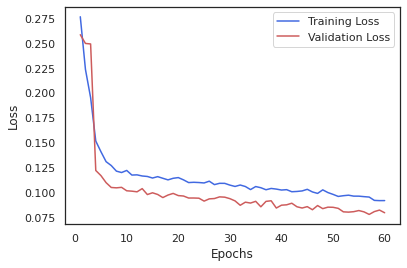

In [68]:
epochs = range(1, len(history.history['loss'])+1)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']


# b+ is for "blue cross"
plt.plot(epochs, training_loss, color='royalblue', label='Training Loss')
# "bo" is for "blue dot"
plt.plot(epochs, validation_loss, color='indianred', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

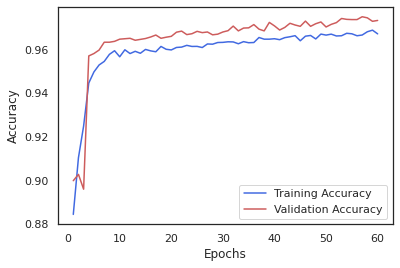

In [69]:
epochs = range(1, len(history.history['loss'])+1)
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']


# b+ is for "blue cross"
plt.plot(epochs, training_acc, color='royalblue', label='Training Accuracy')
# "bo" is for "blue dot"
plt.plot(epochs, validation_acc, color='indianred', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
#model.load_weights('/content/content/model-ft.h5')

## Enviando Predições para o Kaggle (Conjunto de Testes)

In [72]:
predictions = model.predict(test_gen, verbose=1)

57458/57458 [==============================] - 567s 10ms/step


In [73]:
predictions.shape

(57458, 2)

In [74]:
df_preds = pd.DataFrame(predictions, columns=['sem_tumor', 'com_tumor'])

df_preds.head()

,sem_tumor,com_tumor
0,0.000003,0.999997
1,0.000110,0.999890
2,0.025762,0.974238
3,0.000035,0.999965
4,0.999815,0.000185


In [75]:
df_preds['file_names'] = test_gen.filenames

In [76]:
df_preds.head()

,sem_tumor,com_tumor,file_names
0,0.000003,0.999997,test/00006537328c33e284c973d7b39d340809f7271b.tif
1,0.000110,0.999890,test/0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,0.025762,0.974238,test/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,0.000035,0.999965,test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,0.999815,0.000185,test/000270442cc15af719583a8172c87cd2bd9c7746.tif


In [77]:
def extract_id(x):
    a = x.split('/')
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

,sem_tumor,com_tumor,file_names,id
0,0.000003,0.999997,test/00006537328c33e284c973d7b39d340809f7271b.tif,00006537328c33e284c973d7b39d340809f7271b
1,0.000110,0.999890,test/0000ec92553fda4ce39889f9226ace43cae3364e.tif,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.025762,0.974238,test/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.000035,0.999965,test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.999815,0.000185,test/000270442cc15af719583a8172c87cd2bd9c7746.tif,000270442cc15af719583a8172c87cd2bd9c7746


In [79]:
y_pred = df_preds['com_tumor']

image_id = df_preds['id']

In [80]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

In [81]:
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.999997
0000ec92553fda4ce39889f9226ace43cae3364e,0.999890
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.974238
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.999965
000270442cc15af719583a8172c87cd2bd9c7746,0.000185


In [82]:
submission.to_csv('patch_preds.csv', columns=['label']) 

In [83]:
!kaggle competitions submit -c histopathologic-cancer-detection -f /content/patch_preds.csv -m "Submission 01"

100% 2.90M/2.90M [00:00<00:00, 8.63MB/s]
Successfully submitted to Histopathologic Cancer Detection

> ROC AUC Score (Public): 0.9512
>
> ROC AUC Score (Private): 0.9356